In [1]:
from scipy.constants import h, c, k
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as sps
import pandas as pd
import cupy as cp
from scipy.stats import norm, chi2
import scipy
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fsolve
%matplotlib widget


# Plotting format for thesis
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', titlesize=16, labelsize=16)
plt.rc('legend', fontsize=14)
plt.rc('figure', titlesize=18)




In [16]:
def freq2Idx(freqs, freq):
    return int(len(freqs) * freq/max(freqs))

def simSpec(
    N,
    Fs,
    sysTemp,
    p_sig,
    numAvg,
    printInfo = 1
    ):
    """
    Simulates the power spectrum of a signal in the presence of noise.

    Args:
        N (int): Number of samples
        Fs (float): Sampling frequency in MHz
        sysTemp (float): System temperature in Kelvin
        p_sig (float): Power of the signal in watts (delta line shape)
        numAvg (int): Number of averages
        printInfo (bool): If true, prints detailed information about the simulation

    Returns:
        tuple: Frequencies array and computed spectrum
    """

    deltaNuRf = Fs/N*1e6 #Hz 


    p_noise = k*sysTemp*deltaNuRf 
    if printInfo:
        print(f'N bins = {N}')
        print(f'sample rate = {Fs} MHz')
        print(f'delta nu rf = {round(deltaNuRf, 2)} Hz')
        print(f'power of noise / bin = {p_noise} W')
        print(f'expected STD {p_noise / np.sqrt(numAvg)}\n')



    freqs = np.linspace(0, Fs/2, N)
    sigSpec = np.zeros(N)
    sigSpec[freq2Idx(freqs, f)] = p_sig
    spec = np.zeros(N)
    if printInfo:
        print('######### Compute average ##################################')
    for i in range(numAvg):
        noiseSpec = np.random.normal(p_noise, p_noise, size=N)
        spec += (sigSpec+noiseSpec)
        if (i % (numAvg//10) == 0) and printInfo:
            print(f'On avg num: {i}')
    spec /= numAvg
    if printInfo:
        print('######### Computed after simulation from spec ###############\n')
        print(f'mean of spec = {np.mean(spec)}')
        print(f'STD of spec = {np.std(spec)}')
        print(f'STD of spec (via MAD) = {1.4826 * sps.median_abs_deviation(spec)}')
        print(f'(mean/STD)**2/numAvg = {((np.mean(spec) / (1.4826 * sps.median_abs_deviation(spec)))**2) / numAvg} (should be 1)\n')

    return(freqs, spec)

def simSpecFast(
    N,
    Fs,
    sysTemp,
    p_sig,
    numAvg,
    printInfo = 1
    ):
    """
    same as above, but just says std is 1/sqrtN rather than averaging forever
    Simulates the power spectrum of a signal in the presence of noise.

    Args:
        N (int): Number of samples
        Fs (float): Sampling frequency in MHz
        sysTemp (float): System temperature in Kelvin
        p_sig (float): Power of the signal in watts (delta line shape)
        numAvg (int): Number of averages
        printInfo (bool): If true, prints detailed information about the simulation

    Returns:
        tuple: Frequencies array and computed spectrum
    """

    deltaNuRf = Fs/N*1e6 #Hz 


    p_noise = k*sysTemp*deltaNuRf 
    if printInfo:
        print(f'N bins = {N}')
        print(f'sample rate = {Fs} MHz')
        print(f'delta nu rf = {round(deltaNuRf, 2)} Hz')
        print(f'power of noise / bin = {p_noise} W')
        print(f'expected STD {p_noise / np.sqrt(numAvg)}\n')



    freqs = np.linspace(0, Fs/2, N)
    sigSpec = np.zeros(N)
    sigSpec[freq2Idx(freqs, f)] = p_sig
    spec = np.zeros(N)
    if printInfo:
        print('######### Compute average ##################################')

    noiseSpec = np.random.normal(p_noise, p_noise/np.sqrt(numAvg), size=N)
    spec += (sigSpec+noiseSpec)
    
    if printInfo:
        print('######### Computed after simulation from spec ###############\n')
        print(f'mean of spec = {np.mean(spec)}')
        print(f'STD of spec = {np.std(spec)}')
        print(f'STD of spec (via MAD) = {1.4826 * sps.median_abs_deviation(spec)}')
        print(f'(mean/STD)**2/numAvg = {((np.mean(spec) / (1.4826 * sps.median_abs_deviation(spec)))**2) / numAvg} (should be 1)\n')

    return(freqs, spec)

def get_required_sigma(nBins, desired_confidence):    
    """
    Calculate the required standard deviation (sigma) level to achieve a specified
    confidence level that none of the samples in a given number of bins will exceed
    that sigma level.

    The function solves for the sigma level using the cumulative distribution function
    of the normal distribution and the binomial probability for the given number of bins.

    Parameters
    ----------
    nBins : int
        The number of bins or samples drawn from a normal distribution.
    desired_confidence : float
        The desired confidence level (between 0 and 1) for the probability that none
        of the samples will exceed the calculated sigma level. eg 0.95

    Returns
    -------
    float
        The calculated sigma level required to achieve the desired confidence.

    Notes
    -----
    The function uses the `fsolve` method from SciPy's optimize module to solve for
    the sigma value. If the solver does not converge, it returns a guessed value
    based on the inverse error function.
    """

    desired_confidence = 1-desired_confidence
    def probability_greater_than(sigma):
        return 0.5-scipy.special.erf(sigma/np.sqrt(2))/2

    def binomial(N, num_successes, prob_of_success):
        return scipy.special.comb(N, num_successes)*prob_of_success**(num_successes)*(1-prob_of_success)**(N-num_successes)

    def probability_none_above(nBins, sigma):
        # returns probability that after nBins of draws from a normal distribution
        # that none of the draws will be above the sigma upper limit (mean+sigma)
        return 1-binomial(nBins, nBins, 1-probability_greater_than(sigma))

    guess     = scipy.special.erfinv(1-(2*(desired_confidence)/nBins))*np.sqrt(2) #from taylor expantion
    nSig, solDict, itr, msg   = fsolve(lambda sigma: probability_none_above(nBins, sigma)-desired_confidence, guess, full_output=True)
    nSig = nSig[0]
    if itr != 1:
        print('fSolve in get_required_sigma failed. Using guess')
        print(msg)
        nSig = guess
    return nSig 

N bins = 1024
sample rate = 800 MHz
delta nu rf = 781250.0 Hz
power of noise / bin = 4.314528125000001e-15 W
expected STD 4.314528125000001e-17

######### Compute average ##################################
On avg num: 0
On avg num: 1000
On avg num: 2000
On avg num: 3000
On avg num: 4000
On avg num: 5000
On avg num: 6000
On avg num: 7000
On avg num: 8000
On avg num: 9000
######### Computed after simulation from spec ###############

mean of spec = 4.313468109125483e-15
STD of spec = 4.442077741788191e-17
STD of spec (via MAD) = 4.1117857800445756e-17
(mean/STD)**2/numAvg = 1.100505512948352 (should be 1)



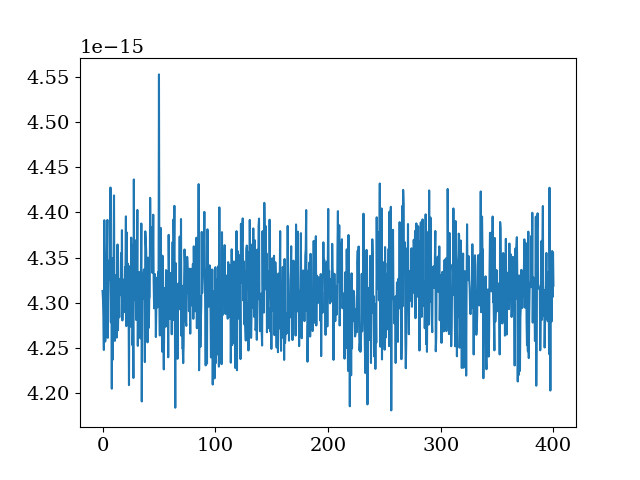

In [17]:
N = 2**10  # Number of samples
Fs = 800    # Sampling frequency (MHz)
freqs = np.linspace(0, Fs/2, N)  #MHz

sysTemp = 400 #K

p_sig = 2e-16  # power of signal [W]
f = 50       # Frequency of the dp signal (MHz)

numAvg = 10000
printInfo = 1 #bool 

freqs, spec = simSpec(N, Fs, sysTemp, p_sig, numAvg, printInfo)

plt.close('all')
plt.plot(freqs, spec);


N bins = 1024
sample rate = 800 MHz
delta nu rf = 781250.0 Hz
power of noise / bin = 4.314528125000001e-15 W
expected STD 4.3145281250000008e-16

######### Compute average ##################################
On avg num: 0
On avg num: 10
On avg num: 20
On avg num: 30
On avg num: 40
On avg num: 50
On avg num: 60
On avg num: 70
On avg num: 80
On avg num: 90
######### Computed after simulation from spec ###############

mean of spec = 4.319161430478205e-15
STD of spec = 4.183085022369402e-16
STD of spec (via MAD) = 4.12656602877431e-16
(mean/STD)**2/numAvg = 1.0955224338613818 (should be 1)

N bins = 1024
sample rate = 800 MHz
delta nu rf = 781250.0 Hz
power of noise / bin = 4.314528125000001e-15 W
expected STD 1.3643735903855668e-16

######### Compute average ##################################
On avg num: 0
On avg num: 100
On avg num: 200
On avg num: 300
On avg num: 400
On avg num: 500
On avg num: 600
On avg num: 700
On avg num: 800
On avg num: 900
######### Computed after simulation from 

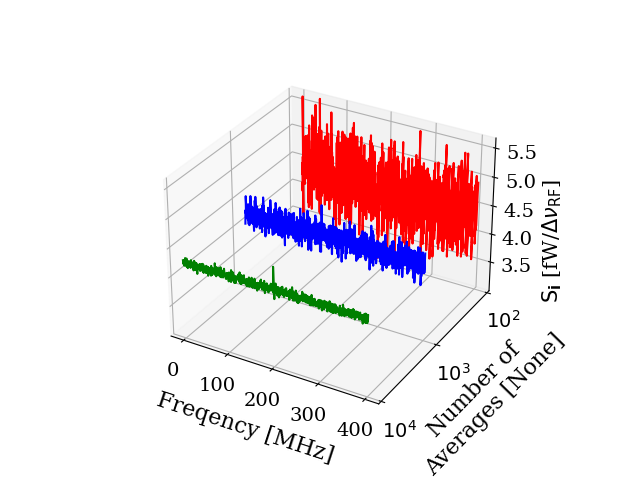

In [18]:

plt.close('all')
'''
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', titlesize=14, labelsize=15)
plt.rc('legend', fontsize=14)
plt.rc('figure', titlesize=18)
'''

N = 2**10  # Number of samples
Fs = 800    # Sampling frequency (MHz)
freqs = np.linspace(0, Fs/2, N)  #MHz

sysTemp = 400 #K

p_sig = 4e-16  # power of signal [W]
f = 200       # Frequency of the dp signal (MHz)
numAvgList = [100,1000,10000]
printInfo = 1 #bool 

pltIdxStart     = freq2Idx(freqs,0)
pltIdxStop     = freq2Idx(freqs, 400)

#simSpec(N, Fs, sysTemp, p_sig, numAvg = 10, printInfo=1)



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['red', 'blue', 'green']  # Add as many colors as needed

for i, numAvg in enumerate(numAvgList):
    freqs, spec = simSpec(N, Fs, sysTemp, p_sig, numAvg, printInfo)
    std_value = np.std(spec * 1e15)
    ax.plot((freqs[pltIdxStart:pltIdxStop]),
            (spec * 1e15)[pltIdxStart:pltIdxStop],
            zs=i, zdir='y', color=colors[i % len(colors)])
    
    # Position the text at the end of each spectrum
    x_pos = freqs[pltIdxStop-1012]
    y_pos = i
    z_pos = (spec * 1e15)[pltIdxStop-1]
    #ax.text(x_pos, y_pos, z_pos, f'STD: {std_value:.2f}', 
    #    color='black', fontsize=14, 
    #    bbox=dict(boxstyle='round', alpha=.75, color=colors[i % len(colors)]), ha='center', va='center')



labelpad =8

ax.set_xlabel(r'Freqency [MHz]', labelpad=labelpad + 1)
ax.set_ylabel('Number of \nAverages [None]', labelpad=labelpad+4)


# Adjust the z-label position manually using a text object
ax.text2D(1.075, .35, r'$\mathrm{S}_\mathbf{i}$' + r' [fW/$\Delta \nu_{\mathrm{RF}}$]', transform=ax.transAxes, rotation=90, fontsize=15)

# Custom ticks for Y-axis
custom_ticks = [0, 1, 2]  # Positions of the ticks
custom_labels = [r'$10^{{{}}}$'.format(int(np.log10(i))) for i in numAvgList]  # Custom labels for the ticks
ax.set_yticks(custom_ticks)
ax.set_yticklabels(custom_labels)
# Invert the y-axis by setting limits
ax.set_ylim(max(custom_ticks), min(custom_ticks))

plt.show()
#plt.savefig('./toyAnalysis3DPlot2.png', bbox_inches='tight', dpi = 300)


In [19]:
get_required_sigma(len(freqs), .95)

3.890156224635755

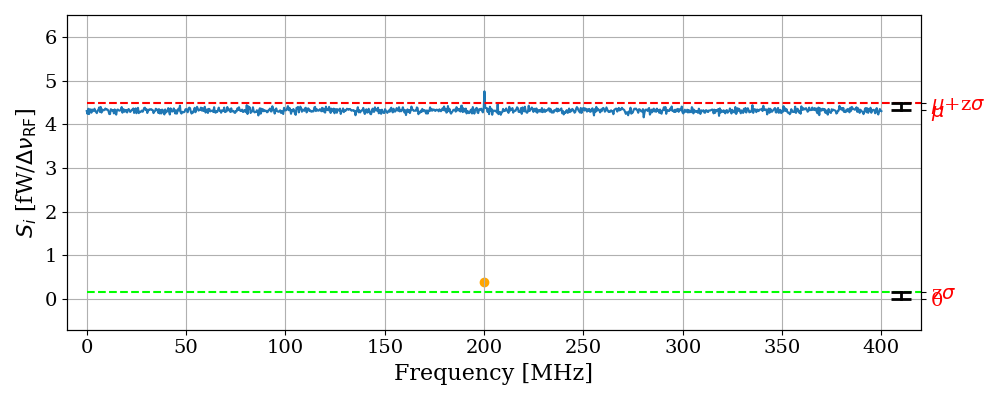

In [71]:
N = 2**10  # Number of samples
Fs = 800    # Sampling frequency (MHz)
freqs = np.linspace(0, Fs/2, N)  #MHz


sysTemp = 400 #K

p_sig = 1*4e-16  # power of signal [W]
f = 200       # Frequency of the dp signal (MHz)
numAvgList = 100
printInfo = 0 #bool 


#colors = ['red', 'blue', 'green']  # Add as many colors as needed

plt.close('all')
specMax = 0
fig, ax = plt.subplots(figsize=(10, 4))

freqs, spec = simSpecFast(N, Fs, sysTemp, p_sig, numAvg, printInfo)
if max(spec) > specMax:
    specMax = max(spec)
plt.plot(freqs, spec*1e15)

z       = get_required_sigma(len(freqs), .95)
sigma   = scipy.stats.median_abs_deviation(spec, scale='normal')*1e15
mu      = np.mean(spec)*1e15

ax.hlines(z*sigma+mu, 0 , 500, color = 'r', linestyle = '--')

ax.hlines(z*sigma, 0 , 500, color = 'lime', linestyle = '--')
ax.scatter(f, p_sig*1e15, color = 'orange')

# Plot the vertical line with arrowheads at both ends
ax.plot([410, 410], [0, z * sigma], 'k', marker='_', markersize=14, markeredgewidth=2, linewidth=2)
ax.plot([410, 410], [mu, mu + (z * sigma)], 'k', marker='_', markersize=14, markeredgewidth=2, linewidth=2)

# Add secondary y-axis with 2 ticks
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks([0,z * sigma,mu, (mu + (z * sigma))])
ax2.set_yticklabels(['0', r'z$\sigma$', r'$\mu$',  r'$\mu$+z$\sigma$'], color='r')

#plt.ylim(-.7, specMax*1e15*1.15)
ax.set_ylim(-.7, 6.5)
ax2.set_ylim(-.7, 6.5)
plt.xlim(-10, 420)
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel(r'$S_i$ [fW/$\Delta \nu_\mathrm{RF}$]')
plt.tight_layout()
ax.grid()


/tmp/ipykernel_323895/4127140898.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


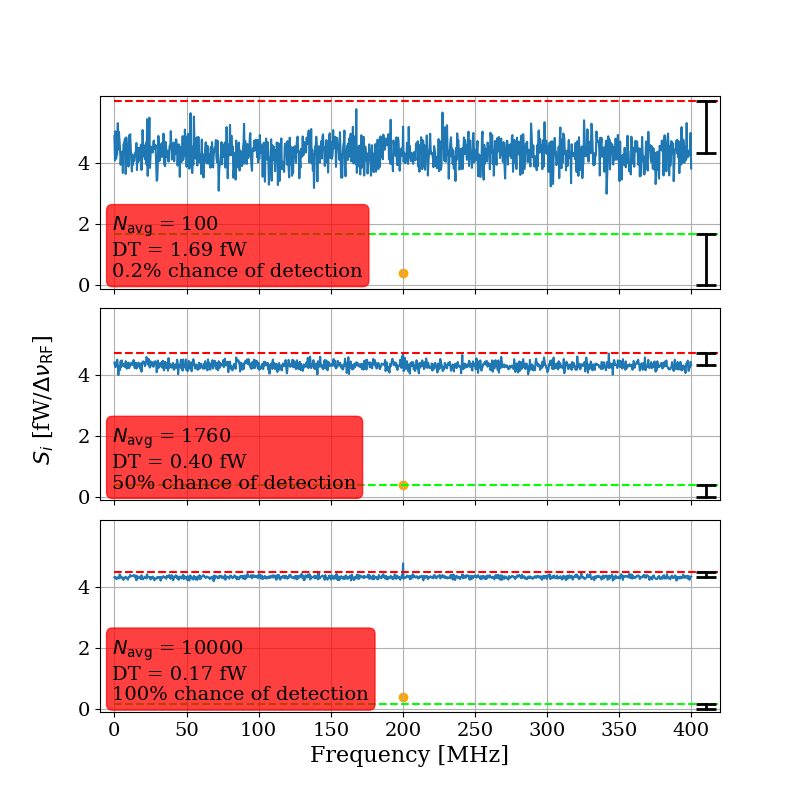

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from matplotlib.gridspec import GridSpec

# Define parameters
N = 2**10  # Number of samples
Fs = 800  # Sampling frequency (MHz)
freqs = np.linspace(0, Fs / 2, N)  # MHz
sysTemp = 400  # K
p_sig = 1 * 4e-16  # power of signal [W]
f = 200  # Frequency of the dp signal (MHz)
numAvgList = [100, 971, 1760, 2782, 10000]
#numAvgList = [971, 1760, 2782]
numAvgList = [100, 1760, 10000]
truePosList =[0.2,16,50,84,100]
truePosList =[0.2,50,100]
printInfo = 0  # bool

plt.close('all')
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(3, 1, hspace=0.1)

for idx, numAvg in enumerate(numAvgList):
    ax = fig.add_subplot(gs[idx, 0])

    freqs, spec = simSpecFast(N, Fs, sysTemp, p_sig, numAvg, printInfo)
    
    z = get_required_sigma(len(freqs), .95)
    sigma = scipy.stats.median_abs_deviation(spec, scale='normal') * 1e15
    mu = np.mean(spec) * 1e15
    
    ax.plot(freqs, spec * 1e15)
    ax.hlines(z * sigma + mu, 0, 500, color='r', linestyle='--')
    ax.hlines(z * sigma, 0, 500, color='lime', linestyle='--')
    ax.scatter(f, p_sig * 1e15, color='orange')

    ax.set_yticks([0,2,4])
    
    # Plot the vertical line with arrowheads at both ends
    ax.plot([410, 410], [0, z * sigma], 'k', marker='_', markersize=14, markeredgewidth=2, linewidth=2)
    ax.plot([410, 410], [mu, mu + (z * sigma)], 'k', marker='_', markersize=14, markeredgewidth=2, linewidth=2)

    # Add text box with title, z*sigma, and mu + z*sigma
    textstr = f'$N_{{\\mathrm{{avg}}}}$ = {numAvg}\nDT = {z * sigma:.2f} fW\n{truePosList[idx]}% chance of detection'
    ax.text(0.02, 0.04, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='bottom', bbox=dict(boxstyle='round', alpha=.75, color='red'))

    # Set labels
    if idx == len(numAvgList) - 1:
        ax.set_xlabel('Frequency [MHz]')
    else:
        ax.tick_params(labelbottom=False)
    
    #ax.set_ylabel(r'$S_i$ [fW/$\Delta \nu_\mathrm{RF}$]')
    ax.grid()
    ax.set_ylim(-0.1, 6.2)
    ax.set_xlim(-10, 420)

# Set common y-axis label
fig.text(0.04, 0.5, r'$S_i$ [fW/$\Delta \nu_\mathrm{RF}$]', va='center', rotation='vertical', fontsize=16)

plt.tight_layout()
plt.show()
plt.savefig('plot.png', bbox_inches='tight', dpi = 300)

2782.2240047976793
971.8276776077764
1760.6811353188775


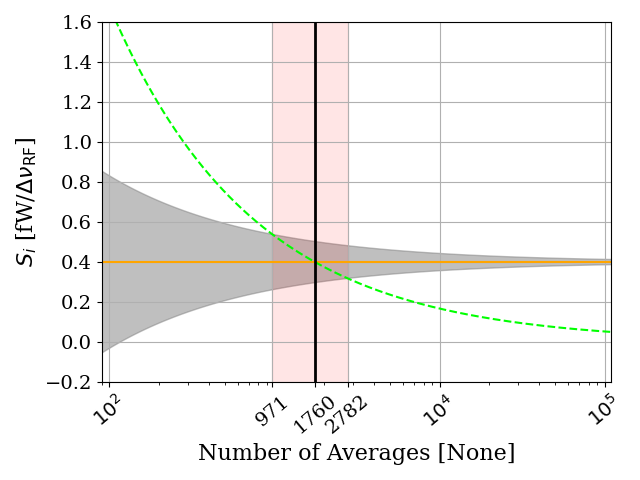

In [98]:
#second attempt at remaking John's plot
from matplotlib.ticker import FuncFormatter

# Generate data 
numAvgArr = np.logspace(1, 6, 1000)#np.linspace(1, 400000, 1000)



N = 2**10  # Number of samples
Fs = 800    # Sampling frequency (MHz)
deltaNuRf = Fs/N*1e6
freqs = np.linspace(0, Fs/2, N)  #MHz

prefix = 1e15 # for plotting. Converts to femtowatts or whatever 

sysTemp = 400 #K
pNoise  = k*sysTemp*deltaNuRf

p_sig = 4e-16  # power of signal [W]
f = 200       # Frequency of the dp signal (MHz)
numAvg = 20000

z       = get_required_sigma(len(freqs), .95)
sigma   = scipy.stats.median_abs_deviation(spec, scale='normal')*prefix
printInfo = 0 #bool 


#signal = 10 / np.sqrt(time)
#uncertainty = signal   

# Plotting
plt.figure()

# Plot the main signal
plt.plot(numAvgArr,np.repeat(prefix*p_sig,len(numAvgArr)), 'orange', label='True Signal Power')

# Plot the uncertainty as a shaded area
plt.fill_between(numAvgArr, prefix* (p_sig + pNoise/np.sqrt(numAvgArr)),  prefix*(p_sig - pNoise/np.sqrt(numAvgArr)), color='gray', alpha=0.5, label = r'1$\sigma$ Uncertanty on Measured Signal')

#plot the limit on power = z sigma
plt.plot(numAvgArr, prefix*z*pNoise*1/np.sqrt(numAvgArr), 'lime', linestyle = '--', label = 'Detection Threshold' )

#some hidden algebra. Set two curves equal and solve for N_avg
plus1sigmaAvgs = ((pNoise/p_sig)*(1+z))**2
minus1sigmaAvgs = ((pNoise/p_sig)*(1-z))**2 
mostLiklyAvgs = (z*pNoise/p_sig)**2
print(plus1sigmaAvgs)
print(minus1sigmaAvgs)
print(mostLiklyAvgs)





#plt.axvline(x=plus1sigmaAvgs, color='k', linestyle='--', label='+1 Sigma Avg')
#plt.axvline(x=minus1sigmaAvgs, color='k', linestyle='--', label='-1 Sigma Avg')
plt.axvline(x=mostLiklyAvgs, color='black', zorder = 1000, linewidth = 2, label = r'Expected $N_\mathrm{avg}$ = 1760')
plt.fill_betweenx(np.linspace(-20, 20, 100), minus1sigmaAvgs, plus1sigmaAvgs, color='red', alpha=0.1, label = r'1$\sigma$ Uncertanty on $N_\mathrm{avg}$')


#plt.xlim(1e2,1e5)
plt.semilogx()
plt.xlabel('Number of Averages [None]')
plt.ylabel(r'$S_i$ [fW/$\Delta \nu_\mathrm{RF}$]')
plt.ylim(-.2, 1.6)
plt.xlim(90, 110000)
#plt.semilogy()
#plt.xticks([250, 500, 750, plus1sigmaAvgs, 1250, 
#    1500, mostLiklyAvgs, minus1sigmaAvgs, 2000,2250, 2500,  3000, 3250, 3500])
#plt.xticks([ 500, plus1sigmaAvgs, 
#    1500, mostLiklyAvgs, minus1sigmaAvgs, 2000, 2500,  3000, 3500])
#plt.xticks([plus1sigmaAvgs, mostLiklyAvgs, minus1sigmaAvgs])
#fuckary to get powers of 10
tick_locations = [100, plus1sigmaAvgs, mostLiklyAvgs, minus1sigmaAvgs, 10000, 100000]

# Define a function to format the ticks
def format_func(value, tick_number):
    if value in [plus1sigmaAvgs, mostLiklyAvgs, minus1sigmaAvgs]:
        return str(int(value))
    else:
        return r'$10^{%d}$' % int(np.log10(value))

#plt.text(200,.9, 'Detection\nThreshold', rotation = -40, color = 'limegreen', fontsize = 16)
#plt.legend()
# Set the major ticks at the specified locations with formatted labels
plt.xticks(tick_locations, rotation = 40)
plt.gca().get_xaxis().set_major_formatter(FuncFormatter(format_func))


plt.grid()
plt.tight_layout()
plt.show()


3.890156224635755 3.8899191360854024
On trial num: 0
On trial num: 10
On trial num: 20
On trial num: 30
On trial num: 40
On trial num: 50
On trial num: 60
On trial num: 70
On trial num: 80
On trial num: 90
num avg = 10000
100.0% True positives
0.0% False negatives
7.000000000000001% False positives
93.0% True negatives
sigma array = 0.043+-0.001
mean array = 4.314+-0.002


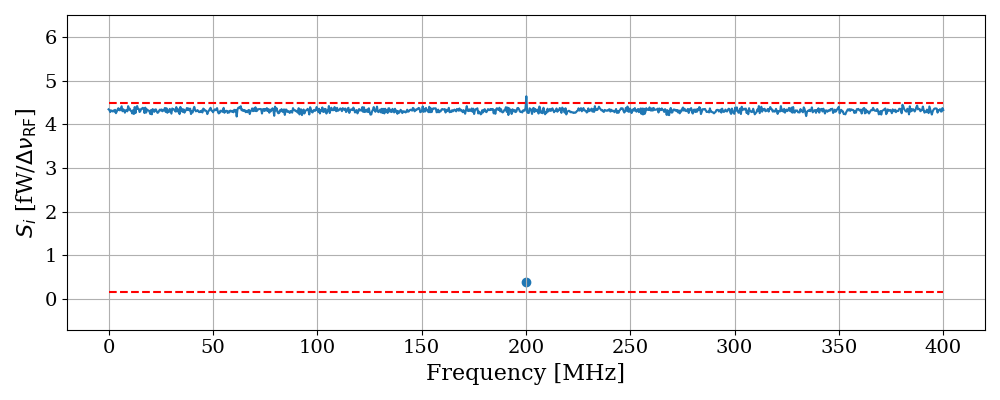

In [8]:
#Monte Carlo

N = 2**10  # Number of samples
Fs = 800    # Sampling frequency (MHz)
freqs = np.linspace(0, Fs/2, N)  #MHz


sysTemp = 400 #K

p_sig = 4e-16  # power of signal [W]
f = 200       # Frequency of the dp signal (MHz)
numAvg = 10000

printInfo = 0 #bool 

NTrials = 100

TP = 0
FN = 0
FP = 0 
TN = 0
stdList = []
meanList =[]
fIdx        =  freq2Idx(freqs, f)
z           = get_required_sigma(len(freqs), .95)
z2          = get_required_sigma(len(freqs)-1, .95) #subtract single bin for sig
print(z, z2)
for i in range(NTrials):
    if (i % (NTrials//10) == 0):
        print(f'On trial num: {i}')
    freqs, spec = simSpecFast(N, Fs, sysTemp, p_sig, numAvg, printInfo)
    sigma       = scipy.stats.median_abs_deviation(spec, scale='normal')
    #sigma       = np.std(spec)
    mu          = np.mean(spec[0:fIdx])
    stdList.append(sigma)
    meanList.append(mu)

    if spec[fIdx] > mu + (z*sigma): 
        #print('signal found (true positive)')
        TP += 1
    else: 
        #print('no signal found (false negative)')
        FN += 1

    if np.any(spec[np.arange(len(spec))!=fIdx] > (mu + (z*sigma))):
        #print('fluctation found (false positive)')
        FP += 1
    else:
        #print('fluctation not found (true negative)')
        TN += 1
print(f'num avg = {numAvg}')
print(f'{TP/NTrials * 100}% True positives')
print(f'{FN/NTrials * 100}% False negatives') 
print(f'{FP/NTrials * 100}% False positives') 
print(f'{TN/NTrials * 100}% True negatives')
print(f'sigma array = {round(np.mean(stdList)*prefix,3)}+-{round(np.std(stdList)*prefix,3)}')
print(f'mean array = {round(np.mean(meanList)*prefix,3)}+-{round(np.std(meanList)*prefix,3)}')

plt.close('all')
specMax = 0
plt.figure(figsize=(10,4))

plt.plot(freqs, spec*prefix)

z       = get_required_sigma(len(freqs), .95)
sigma   = scipy.stats.median_abs_deviation(spec, scale='normal')*prefix
mu      = np.mean(spec[np.arange(len(spec))!=fIdx])*prefix
plt.hlines(z*sigma+mu, 0 , 400, color = 'r', linestyle = '--')

plt.hlines(z*sigma, 0 , 400, color = 'r', linestyle = '--')

plt.scatter(f, p_sig*prefix)

#plt.ylim(-.7, specMax*prefix*1.15)
plt.ylim(-.7, 6.5)
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$S_i$ [fW/$\Delta \nu_\mathrm{RF}$]')
plt.tight_layout()
plt.grid()


In [24]:
#Monte Carlo, same as above but does it in one go and prints the complete MC table.

N = 2**10  # Number of samples
Fs = 800    # Sampling frequency (MHz)
freqs = np.linspace(0, Fs/2, N)  #MHz


sysTemp = 400 #K

p_sig = 4e-16  # power of signal [W]
f = 200       # Frequency of the dp signal (MHz)
numAvgList = [100, 971, 1760, 2782, 10000]

printInfo = 0 #bool 

NTrials = 100000

fIdx        =  freq2Idx(freqs, f)
z           = get_required_sigma(len(freqs), .95)
z2          = get_required_sigma(len(freqs)-1, .95) #subtract single bin for sig

for numAvg in numAvgList:
    TP = 0
    FN = 0
    FP = 0 
    TN = 0
    stdList = []
    meanList =[]
    for i in range(NTrials):
        freqs, spec = simSpecFast(N, Fs, sysTemp, p_sig, numAvg, printInfo)
        #sigma       = scipy.stats.median_abs_deviation(spec, scale='normal')
        sigma       = np.std(spec)
        mu          = np.mean(spec[0:fIdx])
        stdList.append(sigma)
        meanList.append(mu)

        if spec[fIdx] > mu + (z*sigma): 
            #print('signal found (true positive)')
            TP += 1
        else: 
            #print('no signal found (false negative)')
            FN += 1

        if np.any(spec[np.arange(len(spec))!=fIdx] > (mu + (z*sigma))):
            #print('fluctation found (false positive)')
            FP += 1
        else:
            #print('fluctation not found (true negative)')
            TN += 1
    print(f'{numAvg} & {round(TP / NTrials * 100, 1)} & {round(FN / NTrials * 100, 1)} & {round(FP / NTrials * 100, 1)} & {round(TN / NTrials * 100, 1)} \\\\')




KeyboardInterrupt: 

In [25]:
import numpy as np
import scipy.stats
from concurrent.futures import ProcessPoolExecutor
import os

# Simulation parameters
N = 2**10  # Number of samples
Fs = 800  # Sampling frequency (MHz)
freqs = np.linspace(0, Fs / 2, N)  # MHz
sysTemp = 400  # K
p_sig = 4e-16  # power of signal [W]
f = 200  # Frequency of the dp signal (MHz)
numAvgList = [100, 971, 1760, 2782, 10000]
printInfo = 0  # bool
NTrials = 100000
fIdx = freq2Idx(freqs, f)
z = get_required_sigma(len(freqs), .95)
z2 = get_required_sigma(len(freqs) - 1, .95)  # subtract single bin for sig

def compute_metrics(numAvg):
    np.random.seed(os.getpid())
    TP = 0
    FN = 0
    FP = 0 
    TN = 0
    stdList = []
    meanList = []
    
    for i in range(NTrials):
        freqs, spec = simSpecFast(N, Fs, sysTemp, p_sig, numAvg, printInfo)
        sigma = scipy.stats.median_abs_deviation(spec, scale='normal')
        #sigma       = np.std(spec)
        mu = np.mean(spec[0:fIdx])
        stdList.append(sigma)
        meanList.append(mu)

        if spec[fIdx] > mu + (z * sigma):
            TP += 1
        else:
            FN += 1

        if np.any(spec[np.arange(len(spec)) != fIdx] > (mu + (z * sigma))):
            FP += 1
        else:
            TN += 1

    return f'{numAvg} & {round(TP / NTrials * 100, 1)} & {round(FN / NTrials * 100, 1)} & {round(FP / NTrials * 100, 1)} & {round(TN / NTrials * 100, 1)} \\\\'

# Using ProcessPoolExecutor to multithread the outer loop
with ProcessPoolExecutor(max_workers=len(numAvgList)) as executor:
    futures = [executor.submit(compute_metrics, numAvg) for numAvg in numAvgList]
    
    for future in futures:
        print(future.result())


100 & 0.2 & 99.8 & 5.7 & 94.3 \\
971 & 16.3 & 83.7 & 5.5 & 94.5 \\
1760 & 49.8 & 50.2 & 5.7 & 94.3 \\
2782 & 83.8 & 16.2 & 5.7 & 94.3 \\
10000 & 100.0 & 0.0 & 5.6 & 94.4 \\


z =3.890156224635755
numAvg = 1760.6811353188775
pN/pS = 10.786320312500003
pN/pS = 10.786320312500003
pN = 4.314528125000001 fW
mean noise in sig bin = 4.315
std noise in sig bin  = 0.103
p sig                 = 0.4
p sig + mean noise    = 4.715 ± 0.103

################### calculated values from MC ##################
signal bin power      = 4.715 +- 0.097


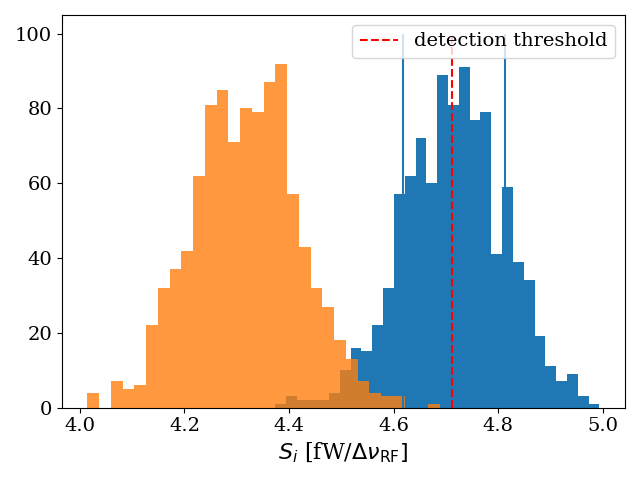

In [57]:
numAvg          = 2102
#numAvg          = 1761 
#numAvg          = 1449
numAvg          = 2800
numAvg          = 1678


p_sig           = 4e-16  # power of signal [W]
p_noise         = (k*sysTemp*deltaNuRf)
pSigPlusNoise   = []
pNoiseBin        = []

numAvg = (p_noise/p_sig*(z))**2
print(f'z ={z}')
print(f'numAvg = {numAvg}')
print(f'pN/pS = {p_noise/p_sig}')
print(f'pN/pS = {p_noise/p_sig}')
print(f'pN = {p_noise*prefix} fW')


for i in range(1000): 
    noise = np.random.normal(p_noise,p_noise/np.sqrt(numAvg))
    pSigPlusNoise.append((noise+p_sig))
    pNoiseBin.append(np.random.normal(p_noise,p_noise/np.sqrt(numAvg)))
plt.close('all')
plt.figure()
plt.hist(np.asarray(pSigPlusNoise)*prefix, bins =30)
plt.hist(np.asarray(pNoiseBin)*prefix, bins=30, alpha = .8)

plt.vlines((np.mean(pSigPlusNoise)+np.std(pSigPlusNoise))*prefix, 0,100)
plt.vlines((np.mean(pSigPlusNoise)-np.std(pSigPlusNoise))*prefix, 0,100)

plt.vlines((np.mean(pNoiseBin)+z*np.std(pNoiseBin))*prefix, 0,100, color = 'r', linestyles='--', label='detection threshold')

plt.xlabel(r'$S_i$ [fW/$\Delta \nu_\mathrm{RF}]$')
plt.tight_layout()
plt.legend()

print(f'mean noise in sig bin = {round(p_noise * prefix, 3)}')
print(f'std noise in sig bin  = {round(p_noise * prefix / np.sqrt(numAvg), 3)}')
print(f'p sig                 = {round(p_sig * prefix, 3)}')
print(f'p sig + mean noise    = {round(prefix * (p_noise + p_sig), 3)} ± {round(prefix * p_noise / np.sqrt(numAvg), 3)}')
print('\n################### calculated values from MC ##################')
print(f'signal bin power      = {round(np.mean(pSigPlusNoise)*prefix, 3)} +- {round(np.std(pSigPlusNoise)*prefix, 3)}')


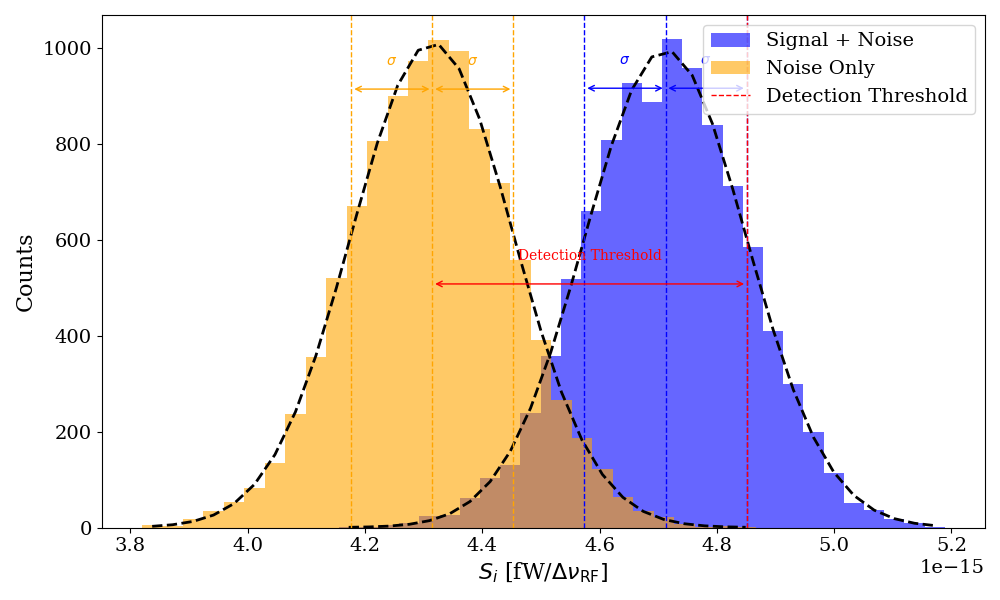

Fractional area covered by the detection threshold: 0.1577


In [63]:
# Noise power per bin
p_noise = k * sysTemp * deltaNuRf

# Generate data
pSigPlusNoise = []
pNoiseBin = []

for i in range(10000):
    noise = np.random.normal(p_noise, p_noise / np.sqrt(numAvg))
    pSigPlusNoise.append(noise + p_sig)
    pNoiseBin.append(np.random.normal(p_noise, p_noise / np.sqrt(numAvg)))

z = get_required_sigma(len(freqs), .95)

# Fit Gaussian to the histograms
mu_sig, std_sig = norm.fit(pSigPlusNoise)
mu_noise, std_noise = norm.fit(pNoiseBin)

# Plot histograms
plt.close('all')
plt.figure(figsize=(10, 6))
count_sig, bins_sig, _ = plt.hist(pSigPlusNoise, bins=30, alpha=0.6, color='blue', label='Signal + Noise', density=False)
count_noise, bins_noise, _ = plt.hist(pNoiseBin, bins=30, alpha=0.6, color='orange', label='Noise Only', density=False)

# Plot Gaussian fit lines
bin_centers_sig = 0.5 * (bins_sig[1:] + bins_sig[:-1])
bin_centers_noise = 0.5 * (bins_noise[1:] + bins_noise[:-1])

plt.plot(bin_centers_sig, norm.pdf(bin_centers_sig, mu_sig, std_sig) * np.diff(bins_sig) * len(pSigPlusNoise), 'k--', linewidth=2)
plt.plot(bin_centers_noise, norm.pdf(bin_centers_noise, mu_noise, std_noise) * np.diff(bins_noise) * len(pNoiseBin), 'k--', linewidth=2)

# Plot vertical lines at mean and ±1 sigma
plt.axvline(mu_sig, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(mu_sig + std_sig, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(mu_sig - std_sig, color='blue', linestyle='dashed', linewidth=1)

plt.axvline(mu_noise, color='orange', linestyle='dashed', linewidth=1)
plt.axvline(mu_noise + std_noise, color='orange', linestyle='dashed', linewidth=1)
plt.axvline(mu_noise - std_noise, color='orange', linestyle='dashed', linewidth=1)


# Add vertical line for detection threshold
z = get_required_sigma(len(freqs), .95)
plt.axvline(mu_noise + std_noise * z, color='red', linestyle='dashed', linewidth=1, label='Detection Threshold')
plt.annotate('', xy=(mu_noise, max(count_noise) * 0.5), xytext=(mu_noise + std_noise * z, max(count_noise) * 0.5), 
             arrowprops=dict(arrowstyle='<->', color='red'))
plt.text(mu_noise + std_noise * z / 2, max(count_noise) * 0.55, 'Detection Threshold', color='red', ha='center')


# Add horizontal arrows from mean to each standard deviation
plt.annotate('', xy=(mu_sig, max(count_sig) * 0.9), xytext=(mu_sig + std_sig, max(count_sig) * 0.9), arrowprops=dict(arrowstyle='<->', color='blue'))
plt.annotate('', xy=(mu_sig, max(count_sig) * 0.9), xytext=(mu_sig - std_sig, max(count_sig) * 0.9), arrowprops=dict(arrowstyle='<->', color='blue'))
plt.text(mu_sig + std_sig / 2, max(count_sig) * 0.95, r'$\sigma$', color='blue', ha='center')
plt.text(mu_sig - std_sig / 2, max(count_sig) * 0.95, r'$\sigma$', color='blue', ha='center')

plt.annotate('', xy=(mu_noise, max(count_noise) * 0.9), xytext=(mu_noise + std_noise, max(count_noise) * 0.9), arrowprops=dict(arrowstyle='<->', color='orange'))
plt.annotate('', xy=(mu_noise, max(count_noise) * 0.9), xytext=(mu_noise - std_noise, max(count_noise) * 0.9), arrowprops=dict(arrowstyle='<->', color='orange'))
plt.text(mu_noise + std_noise / 2, max(count_noise) * 0.95, r'$\sigma$', color='orange', ha='center')
plt.text(mu_noise - std_noise / 2, max(count_noise) * 0.95, r'$\sigma$', color='orange', ha='center')

# Labels and legend
plt.xlabel(r'$S_i$ [fW/$\Delta \nu_\mathrm{RF}]$')
plt.ylabel('Counts')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Calculate the detection threshold
detection_threshold = mu_noise + std_noise * z

# Calculate the CDF value at the detection threshold
fractional_area = 1 - norm.cdf(detection_threshold, loc=mu_sig, scale=std_sig)

print(f'Fractional area covered by the detection threshold: {fractional_area:.4f}')
